<font size = 14>            **Volcanic eruption Introduction**</font>


**Detecting volcanic eruptions before they happen is an important problem that has historically proven to be a very difficult. This competition provides you with readings from several seismic sensors around a volcano and challenges you to estimate how long it will be until the next eruption. The data represent a classic signal processing setup that has resisted traditional methods.**

Volcanologists attempt to forecast volcanic eruptions, but this has proven to be nearly as difficult as predicting an earthquake. Many pieces of evidence can mean that a volcano is about to erupt, but the time and magnitude of the eruption are difficult to pin down. This evidence includes the history of previous volcanic activity, earthquakes, slope deformation, and gas emissions.

# Earthquakes due to activity of volcano

**Moving magma shakes the ground, so the number and size of earthquakes increases before an eruption. A volcano that is about to erupt may produce a sequence of earthquakes. Scientists use seismographs that record the length and strength of each earthquake to try to determine if an eruption is imminent. Magma and gas can push the volcano’s slope upward. Most ground deformation is subtle and can only be detected by tiltmeters, which are instruments that measure the angle of the slope of a volcano. But ground swelling may sometimes create huge changes in the shape of a volcano. Mount St. Helens grew a bulge on its north side before its 1980 eruption. Ground swelling may also increase rockfalls and landslides.**

These earthquakes can be treated as vibrations and our sensor data has recordings of them 

![](https://images.theconversation.com/files/109822/original/image-20160201-32240-8oqf5e.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1200&h=1200.0&fit=crop)

In [ ]:
import os                        # file handling
import numpy as np               # linear algebra
import pandas as pd              # data processing, CSV file I/O (e.g. pd.read_csv)/
import matplotlib.pyplot as plt  # Data Visuaization  
from tqdm import tqdm            # Progress Bar 

In [ ]:
train_data_items = pd.read_csv('../input/predict-volcanic-eruptions-ingv-oe/train.csv')
print(train_data_items.head(),'\n\n')
print(train_data_items.describe(), "\n\n")
print(train_data_items.info(), "\n\n")
print(train_data_items.dtypes, '\n\n')
print(train_data_items.count(), '\n\n')

# **Showing the number of Segment_ids for Training**

In [ ]:
listing_training_sensors = os.listdir('../input/predict-volcanic-eruptions-ingv-oe/train')
print(pd.Series(listing_training_sensors).shape[0])

In [ ]:
#### Checking if data of some training segments is missing ####


# function to remove ".csv" from a string

def removing_CSV(arr):
    return arr[0:len(arr)-4]

##########################

listing_training_sensors = list(map(removing_CSV, listing_training_sensors))

if listing_training_sensors.sort() == list(train_data_items.segment_id).sort():
    print("Yes we have data for all the training segment_ids")
    
train_data_items.sort_values(by = 'time_to_eruption', inplace =True)    

In [ ]:
train_data_items.nunique()

# Creating a hexbin plot to check the randomness in Time to eruption

In [ ]:
train_data_items.plot.hexbin(x= "segment_id",y ="time_to_eruption",gridsize=25, figsize = (10,10))
plt.show()

<font size="3">The Hexbin Plot is clearly showing that the time of erruption is quite random and flat distributed so now let's dig into the data of sensors 

**<font size="5">Some information about Sensors:</font>**
1. generally sensors are placed in an array in different locations near the volcano
2. these sensors are seismic sensors and it might be possible that they would have recorded noise due to external factors 
3. Last point I would like to mention is that a higher magnitude of sensor reading might account for less time remaining      for net erruption
    
Our furthur findings will be based on these points    
</font>

![volcanic Erruptuon](https://www.digikey.com/-/media/Images/Article%20Library/TechZone%20Articles/2015/September/Sensors%20Play%20a%20Key%20Role%20in%20Monitoring%20Active%20Volcanoes/article-2015september-sensors-play-a-key-fig1.jpg?la=en&ts=9291b831-343e-4970-a9cb-4accac3f54f8)

# Now Looking into Data of Sensors

In [ ]:
# taking a sample file to see how it looks like 

Segment_1 = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/train/1000015382.csv")
Segment_1.plot(subplots = True, layout = (5,2), figsize = (20,15))
plt.show()

# Now Let's try to Visualize the difference between values of sensors in segment ids which are having the maximum and the minimum value of time_of_eruption

In [ ]:
# segment_id_min_time = Segment id with minimum time to erruption in train.csv
# segment_id_max_time = Segment id with maximum time to erruption in train.csv



segment_id_min_time = train_data_items[train_data_items["time_to_eruption"] == min(train_data_items["time_to_eruption"])]['segment_id']
segment_id_max_time = train_data_items[train_data_items["time_to_eruption"] == max(train_data_items["time_to_eruption"])]['segment_id']
print(f"Segment_id with maximum time ({ max( train_data_items.time_to_eruption )}) to erruption is {int(segment_id_max_time)}")
print(f"Segment_id with maximum time ({min(train_data_items.time_to_eruption)}) to erruption is {int(segment_id_min_time)}")

<font size = '3' > 
I am assuming that big differeces between the values of sensor data with segment_Id of minimum and maximum time to erruption will be seen by me 😄😁😁
   lets check this hypothesis
</font>
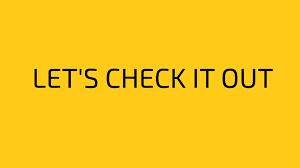

In [ ]:
sensor_max_time = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/train/"+ str(int(segment_id_max_time)) +".csv")
sensor_max_time.plot(subplots = True, layout = (5,2), figsize = (20,15), title = 'Plotting Sensor Data of Segment_id with maximum time to eruption')
plt.show()

In [ ]:
sensor_min_time = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/train/"+ str(int(segment_id_min_time)) +".csv")

sensor_min_time.plot(subplots = True, layout = (5,2), figsize = (20,15),title = 'Plotting Sensor Data of Segment_id with maximum time to eruption')
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 10})
sensor_min_time.plot(subplots = True, layout = (1,10), figsize = (60,5),title = 'Minimum Time Segment')
sensor_max_time.plot(subplots = True, layout = (1,10), figsize = (60,5),title = "Maximum Time Segment")
plt.show()

<font size = '3'>It can be clearly seen that these segment IDs have some missing sensors so we can not propagate this way ,
**But the important thing is that data has some peaks, it may be noise also so let's try to clip and clean the sensors data by clipping through 99 percentile of the recorded readings**</font>

# Finding the outliers and Noise in Data Of Sensors

<font size = '3'>First lets consider only the sensor_1 data of the segment_id with minimum time_to_erruption
to Get the things done in proper way ,
NOTE : we need to calculate separate percentiles for the positive and negative readings of sensors</font>

<font size = '4'> **let me show you what i mean** </font>

<font size = '3'>
I have separated the postive and negative values for the percentile analysis and their plots are shown below
</font>

In [ ]:
positive_values = sensor_min_time[sensor_min_time['sensor_1'] > 0]['sensor_1']
negative_values = sensor_min_time[sensor_min_time['sensor_1'] <= 0]['sensor_1']
spliter_df = pd.DataFrame({'positive_values' : positive_values,
                           'negative_values' : negative_values})
spliter_df["Actual_sensor_data"] =  sensor_min_time['sensor_1']

spliter_df.Actual_sensor_data.plot(figsize = (20,5), ylabel = "Actual values",fontsize = 20,title = "Actual values of Sensor 1",color = 'y')
plt.show()
spliter_df[['negative_values','positive_values']].plot(figsize = (20,5), ylabel = "Negative values",fontsize = 20,title = "Negative values of Sensor 1",colormap = 'winter')
plt.show()

In [ ]:
# finding different percentile values for our Data in sensor 1
percent_dict = dict()
for i in range(1,101):
#     print(f"{i} percentile value :",end = ' ')
#     print("{0:.2f}".format(np.percentile(sensor_min_time[sensor_min_time['sensor_1'] > 0]['sensor_1'],i)))
    percent_dict[i] = np.percentile(sensor_min_time[sensor_min_time['sensor_1'] > 0]['sensor_1'],i)

plt.figure(figsize = (30,10), facecolor = 'w',edgecolor = 'g') 
plt.grid(True)
plt.bar(list(percent_dict.keys()),list(percent_dict.values()), tick_label = list(range(1,101)), color = 'y')
plt.show()


# counting the number of values under each percentile
check_df = pd.DataFrame()
values = []
for i in range(1,101):
    values.append(len(sensor_min_time[sensor_min_time['sensor_1'] > percent_dict[i]]['sensor_1']))
    
check_df = pd.DataFrame({'Percentile': list(range(1,101)),
                         'No of values ahead': values})

In [ ]:
# lets see how many values are greater than 99 percentile
print("99 percentile : ", np.percentile(sensor_min_time[sensor_min_time['sensor_1'] > 0]['sensor_1'],99))
print("Total postive values are : ", sensor_min_time[sensor_min_time['sensor_1'] > 0]["sensor_1"].count())
print("the number of values greater than 99 percentile are :", sensor_min_time[sensor_min_time['sensor_1'] > np.percentile(sensor_min_time[sensor_min_time['sensor_1'] > 0]['sensor_1'],99)]['sensor_1'].count())
print("ratio :", (sensor_min_time[sensor_min_time['sensor_1'] > 0]["sensor_1"].count()/sensor_min_time[sensor_min_time['sensor_1'] > np.percentile(sensor_min_time[sensor_min_time['sensor_1'] > 0]['sensor_1'],99)]['sensor_1'].count())**-1)

# 300 values can spike up the central tendency of the data a lot !!!!

<font size = 4>
We have assumed that these immediate spikes are due to some frequent explosions inside the active volcano and the prediction of time_of_erruption should totally depend on the continuous vibrations produced by the active volcano the standard deviation and mean values of the readings from each sensor must be
stable and for a volcano having low value of time_of_erruption the mean and standard deviation values must be higher since high amplitude waves will be generated from a active volcano
</font>

In [ ]:

print("Displaying differences between successive percentile values: \n".upper() )   
for i in range(80,101):
    print(f"{i} percentile - {i-1} percentile :",end = ' ')
    diff = np.percentile(sensor_min_time[sensor_min_time['sensor_1'] > 0]['sensor_1'],i) - np.percentile(sensor_min_time[sensor_min_time['sensor_1'] > 0]['sensor_1'],i-1)
    print("{0:.2f}".format(diff))

# Lets write logic to clip these spike values from the sensor data 

In [ ]:
def clipped(arr, after = 99): 
    upper_bound = np.percentile(arr[arr > 0],after)
    lower_bound = -np.percentile(-arr[arr <= 0], after)
    return np.clip(arr, a_min = lower_bound, a_max = upper_bound)

<font size = 5><bold>
Let's visualize the outputs of this clipper function on some Samples
</bold></font>


<bold>You can clearly see the difference in data after clipping</bold> 

In [ ]:
arr = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/train/1002275321.csv")

for i in list(arr.columns):
    if not arr[i].isnull().values.all():
        arr[i+'clipped'] = clipped(arr[i])
    else:
        arr[i+'clipped'] = arr[i]
        
column_list = ['sensor_1', 'sensor_1clipped',
       'sensor_2', 'sensor_2clipped', 'sensor_3', 'sensor_3clipped',
       'sensor_4', 'sensor_4clipped', 'sensor_5', 'sensor_5clipped',
       'sensor_6', 'sensor_6clipped', 'sensor_7', 'sensor_7clipped',
       'sensor_8', 'sensor_8clipped', 'sensor_9', 'sensor_9clipped',
       'sensor_10', 'sensor_10clipped',]

arr = arr[column_list]

arr.plot(subplots = True, layout = (10,2),figsize =(20,60), sharex = True,sharey =True ,colormap = 'winter')
plt.show()

# Making the Dataset Developing Function 

In [ ]:
def fft_analysis(arr):
    inspection  = arr
    transformed = np.fft.fft(inspection,len(inspection))
    psd = transformed*np.conjugate(transformed)/len(transformed)
    frequencies = np.arange(len(transformed))
    border = np.ones(len(frequencies)) * np.percentile(psd**2,99)
    
    index = psd < border
    rectified_fft = transformed*index
    inversed = np.fft.ifft(rectified_fft)
    return inversed.real,rectified_fft



def develop_data(arr,segment_id, appending = pd.DataFrame()):
    appending['segment_id'] = [int(segment_id)]
    arr.fillna(0)
    for i in list(arr.columns):
        if (not arr[i].isnull().values.all()) and (arr[i].any()):
            arr[i] = clipped(arr[i])
            rect_1,fft_1 = fft_analysis(arr[i])
            
            fft_1_real  = pd.Series(fft_1.real)
            fft_1_imag  = pd.Series(fft_1.imag)
            rect_1      = pd.Series(rect_1)
            
            
            appending['mean_' + i]    = [float(arr[i].sum())]
            appending['median_' + i]  = [float(arr[i].median())]
            appending['skew_' + i]    = [float(arr[i].skew())]
            appending['mad_'  + i]    = [float(arr[i].mad())]
            appending['min_' + i]     = [float(arr[i].min())]
            appending['max_' + i]     = [float(arr[i].max())]
            appending['kurtosis_' + i]= [float(arr[i].kurtosis())]
            
            appending['rectified_mean_'+i]              = [float(rect_1.sum())]
            appending['rectified_median_'+i]            = [float(rect_1.median())]
            appending['rectified_skew_'+i]              = [float(rect_1.median())]
            appending['rectified_mad_'+i]               = [float(rect_1.mad())]
            appending['rectified_min_'+i]               = [float(rect_1.min())]
            appending['rectified_max_'+i]               = [float(rect_1.max())]
            appending['rectified_kurtosis_'+i]          = [float(rect_1.kurtosis())]
            
            appending['fft_1_real_mean_'+i]              = [float(fft_1_real.sum())]
            appending['fft_1_real_median_'+i]            = [float(fft_1_real.median())]
            appending['fft_1_real_skew_'+i]              = [float(fft_1_real.median())]
            appending['fft_1_real_mad_'+i]               = [float(fft_1_real.mad())]
            appending['fft_1_real_min_'+i]               = [float(fft_1_real.min())]
            appending['fft_1_real_max_'+i]               = [float(fft_1_real.max())]
            appending['fft_1_real_kurtosis_'+i]          = [float(fft_1_real.kurtosis())]


            appending['fft_1_imag_mean_'+i]              = [float(fft_1_imag.sum())]
            appending['fft_1_imag_median_'+i]            = [float(fft_1_imag.median())]
            appending['fft_1_imag_skew_'+i]              = [float(fft_1_imag.median())]
            appending['fft_1_imag_mad_'+i]               = [float(fft_1_imag.mad())]
            appending['fft_1_imag_min_'+i]               = [float(fft_1_imag.min())]
            appending['fft_1_imag_max_'+i]               = [float(fft_1_imag.max())]
            appending['fft_1_imag_kurtosis_'+i]          = [float(fft_1_imag.kurtosis())]
            

    return appending    

training_data_frame = pd.DataFrame() 
for i in tqdm(list(train_data_items.segment_id) , desc = "Prepairing Training Data" , total = len(list(train_data_items.segment_id))):
    segment_id = i
    raw = pd.read_csv(f"../input/predict-volcanic-eruptions-ingv-oe/train/{i}.csv")
    training_data_frame = training_data_frame.append(develop_data(raw,segment_id), ignore_index=True)
    
testing_data_frame = pd.DataFrame()
for i in tqdm(os.listdir('../input/predict-volcanic-eruptions-ingv-oe/test'), desc = "Preparing Testing Data", total = len(os.listdir('../input/predict-volcanic-eruptions-ingv-oe/test'))):
    segment_id = int(i[0:len(i)-4])
    raw = pd.read_csv(f"../input/predict-volcanic-eruptions-ingv-oe/test/{i}")
    testing_data_frame  = testing_data_frame.append(develop_data(raw,segment_id), ignore_index=True)

training_data_frame.shape

In [ ]:
training_data_frame.to_csv("./training_data_frame.csv")
testing_data_frame.to_csv("./testing_data_frame.csv")
training_data_frame.head(5)
print(testing_data_frame.shape)

In [ ]:
training_data_frame = training_data_frame.fillna(0)
training_data_frame = pd.merge(training_data_frame ,train_data_items , on = 'segment_id')
training_data_frame

In [ ]:
data = training_data_frame.copy()

In [ ]:
testing_data_frame = testing_data_frame.fillna(0)

# Preparing the lightGBM with MAE(Mean Absolute Error) and training the model

In [ ]:
import lightgbm as lgbm
from sklearn.model_selection import KFold
import gc

n_fold = 7
folds = KFold(n_splits=n_fold, shuffle=True, random_state=101)
features = list(data.drop(["segment_id", "time_to_eruption"], axis=1).columns)
target_name = ["time_to_eruption"]

params = {
    "n_estimators": 2000,
    "boosting_type": "gbdt",
    "metric": "mae",
    "num_leaves": 66,
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "agging_freq": 3,
    "max_bins": 2048,
    "verbose": 0,
    "random_state": 101,
    "nthread": -1,
    "device": "cpu",
}

sub_preds = np.zeros(testing_data_frame.shape[0])
feature_importance = pd.DataFrame(index=list(range(n_fold)), columns=features)

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data)):
    print(f"Fold {n_fold}:")
    trn_x, trn_y = data[features].iloc[trn_idx], data[target_name].iloc[trn_idx]
    val_x, val_y = data[features].iloc[val_idx], data[target_name].iloc[val_idx]
    
    model = lgbm.LGBMRegressor(**params)
    
    model.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric="mae", verbose=200, early_stopping_rounds=50
           )

    feature_importance.iloc[n_fold, :] = model.feature_importances_
    sub_preds += model.predict(testing_data_frame[features], num_iteration=model.best_iteration_) / folds.n_splits

# Creating Submission file

In [ ]:
submission = pd.DataFrame()
submission['segment_id'] = testing_data_frame["segment_id"]
submission['time_to_eruption'] = sub_preds
submission.to_csv('submission.csv', header=True, index=False)

In [ ]:
import numpy as np
import base64
from IPython.display import HTML
import pandas as pd

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a random sample dataframe
df = pd.DataFrame(np.random.randn(50, 4), columns=list('ABCD'))

# create a link to download the dataframe
create_download_link(df)

# ↓ ↓ ↓  Yay, download link! ↓ ↓ ↓ 
create_download_link(submission, filename = "submissions.csv")